#  Geolocalisation 1D avec e_tp variable (Partie 4.7.2)

---
---

Au lieu de chercher à déterminer une erreur moyenne sur le temps de propagation (e_tp), l'idée est de travailler avec une erreur variable selon la distance qui sépare le récepteur et la source. En effet, plus le récepteur est proche d'une source, plus l'erreur est faible.

Dans l’exemple étudié dans la partie 4.6, au large du Golfe de Gascogne, nous pouvons définir trois zones distinctes : 

— distance inférieure à 15 km : l’erreur est très faible, d’environ 10m (soit 7ms).

— distance entre 15 et 60km : l’erreur est plutôt aux alentours de 150m (soit 100ms).

— distance supérieure à 60km : erreur très importante , d'environ 500m (soit 327ms).

---
---

In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2

# import libraries
import numpy as np
import matplotlib.pyplot as plt
from clib.geolocation_1D import *

---
---
# 1 - Création d'un ensemble de 3 sources

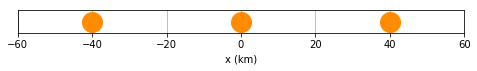

In [2]:
### create an ensemble of sources
dx=50. *1.e3 # in meters
sources3=[]
sources3.append(source( dx*0., 0))
sources3.append(source(-dx*.8, 0))
sources3.append(source( dx*.8, 0))
Ns = len(sources3)

# init a receiver
r=receiver(-30. *1.e3, 0, e_x=10.e3, e_dt=0.)

### plot
plt.figure(figsize=(8,1.5))
ax=plt.subplot(111)
[s.plot() for s in sources3]
#r.plot()
plt.ylim([-3, 3])
plt.xlim([-60.,60.])
ax.grid()
ax.set_aspect('equal')
ax.get_yaxis().set_visible(False)
plt.xlabel('x (km)')
plt.show()

**- Incertitudes a priori : **

In [3]:
print("e_dx  = %.1f m     (uncertainty on transducer position)" %sources3[0].e_dx)
print("e_x   = %.1f m  (uncertainty on underwater float position)" %r.e_x)

e_dx  = 10.0 m     (uncertainty on transducer position)
e_x   = 10000.0 m  (uncertainty on underwater float position)


**- Variables inchangées durant les simulations :  **

In [4]:
print("s.x_t :", [s.x_t for s in sources3])   # due to uncertainty on transducer position 
print("s.dx  :", [s.dx for s in sources3])

s.x_t : [array([-3.22220424]), array([-39990.75380485]), array([40009.94266276])]
s.dx  : [array([-3.22220424]), array([9.24619515]), array([9.94266276])]


---
---
---
# 2 - Fonction de cacluls et de tracé des transects

**- Function "simu" : simulations pour 1 position de récepteur. Renvoie les rms et biais.  **

In [5]:
def simu (r, sources, Nmc, var, t_drift) : 
    ''' It returns rms and bias on x position for one receiver position'''
    x=np.zeros(Nmc)
    y=np.zeros(Nmc)
    dt=np.zeros(Nmc)
    su = np.zeros (Nmc)
    
    for i in range(Nmc):
        
        if var == 'celerity' : 
            [s.draw_celerity(s.e_c) for s in sources]
        if var == 'dxdy' : 
            [s.draw_dxdy(10.) for s in sources]
        if var == 'clock' : 
            r.draw_clock_drift()
            #dt_truth[i] = r.dt    
        
        # solve a first time
        r.t_r_tilda = np.array([s.t_e+pmap.draw_t(dist(s,r))+r.dt for s in sources]).squeeze()
        x[i], dt[i], success, message, res = geolocalize_xtmap_1D(r, sources, pmap0, clock_drift=t_drift)
        # rerun with adjusted expected errors on propagation time
        for j in range(1):
            x[i], dt[i], success, message, res = geolocalize_xtmap_1D(r, sources, pmap, \
                                                                         clock_drift=t_drift, \
                                                                         x0=[x[i], dt[i]])        
        if success :
            su[i] = 1 
        elif message.find('iterations')!= -1 : 
            # "Warning: Maximum number of iterations has been exceeded."
            su[i] = -1
        elif message.find('precision loss')!= -1 :
            #Warning: Desired error not necessarily achieved due to precision loss.
            su[i] = -2
        else : 
            su[i] = -3
    
    
    # rms error on the receiver position
    d_rms = np.sqrt( np.mean( (x[np.where(su==1)] - r.x)**2 ) )
    # biais on the receiver position
    bias_x = x[np.where(su==1)].mean()-r.x
    bias_y = y[np.where(su==1)].mean()-r.y
    #print('x[np.where(su==1)].mean() :' , x[np.where(su==1)].mean())
    #print('r.x : ', r.x)
    return (d_rms, bias_x, su)




**- Fonctions de calculs et tracés pour les transects : **

In [6]:
from ipywidgets import FloatProgress
from IPython.display import display


def transect (sources, X, Y, Nmc, var, clock_drift = False, e_dt=0.01) :
    RMS_t = np.zeros((len(X)))
    BiasX_t = np.zeros((len(X)))
    Success_t = np.zeros((Nmc, len(X)))
    
    r = receiver(X[0], Y, e_dt=e_dt)
    r_dt = r.dt
    
    f = FloatProgress(value = 0., min=0., max=100., step=1., orientation='horizontal', description = 'Loading :')
    display(f)
    
    for i in range (len(X)) :
        
        f.value = i/len(X)*100.

        # init a receiver
        r = receiver(X[i], Y, e_dt=e_dt)
        #print('position réelle r : ', r.x)
        #r.dt = r_dt # unchanged variable during simulations 
        #
        d_rms, bias_x, su = simu (r, sources, Nmc, var = var, t_drift = clock_drift)

        RMS_t[i]       = d_rms
        BiasX_t[i]     = bias_x
        Success_t[:,i] = su

    f.value = 100.
    
    return RMS_t, BiasX_t, Success_t


def plot_transect (sources, X, Y, RMS_t, Biais_t):
    print('mean (rms) = %.1fm  /// max (rms) = %.1f m' % (np.mean(RMS_t), np.max(RMS_t)))
    print('mean (bias) = %.1fm /// max (bias) = %.1f m' % (np.mean(Biais_t), np.max(Biais_t)))
    plt.figure(figsize=(17,4))
    # plot sources 
    ax=plt.subplot(131)
    [s.plot() for s in sources]
    plt.title ('sources and transect')
    plt.xlabel('x [km]')
    plt.ylabel('y [km]')
    ax.grid()
    #ax.set_xlim([np.min(X)/1000.,np.max(X)/1000.])
    ax.set_ylim([-abs(sources[0].y_s)/1000. - 5., abs(sources[0].y_s)/1000. + 5.])
    ax.set_aspect('equal')
    plt.plot([np.min(X)/1000.,np.max(X)/1000.],[Y/1000.,Y/1000.],'.-b')

    ## plot rms result
    ax2 = plt.subplot(132)
    ax2.grid()
    plt.plot(X/1.e3, RMS_t, '.') 
    plt.xlabel('x [km]')
    plt.ylabel('RMS [m]')
    plt.title('RMS error' )
    
    ## plot bias
    ax3  = plt.subplot(133)
    ax3.grid()
    plt.plot(X/1.e3, Biais_t, '.')
    plt.xlabel('x [km]')
    plt.ylabel('Bias [m]')
    plt.title('Bias on x ' )
    
    plt.show()
    

---
---
# 3 - Initialisation du mapping (avec l'erreur e_tp variable) 

In [7]:
### Position des sources
[s.x_s for s in sources3]

[0.0, -40000.0, 40000.0]

In [8]:
### Fonction définissant la variabilité de e_tp
def func_var(dist) : 
    if dist < 15000. :
        return 0.007   # 10m soit 7ms
    if np.logical_and(dist>=15000, dist <60000.) :
        return 0.1     # 150m soit 100ms
    else : 
        return 0.327   # 490m soit 327ms

In [9]:
### Initialisation du mapping
pmap0 = xtmap(c_b=1500., e_c=0., e_t=0.1, e_min=1.e-3)       # erreur constante
pmap = xtmap(c_b=1500., e_c=0., e_t=func_var, e_min=1.e-3)   # erreur variable

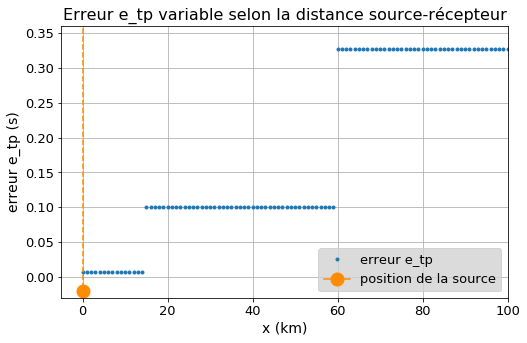

In [10]:
### Plot des erreurs en fonction des posiitons des sources
plt.figure(figsize=(8,5))
xx = np.arange(0,150000,1000)
plot_etp = np.array([pmap.e_tp(x) for x in xx])

plt.plot(xx/1000.,plot_etp, '.', label='erreur e_tp')
plt.title('Erreur e_tp variable selon la distance source-récepteur', fontsize=16)
plt.xlabel('x (km)', fontsize=14)
plt.ylabel('erreur e_tp (s)', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.plot(sources3[0].x_s/1.e3, -0.02, color='darkorange', marker='o', markersize=13, \
         label='position de la source')
plt.plot([sources3[0].x_s/1.e3,sources3[0].x_s/1.e3],[-0.05,0.40],'--', color='darkorange')

plt.xlim([-5,100.])
plt.ylim([-0.03,0.36])
plt.legend(fontsize=13, facecolor='lightgrey')
plt.grid()

plt.savefig('erreur_variable', dpi=100)

---
---

# 3 - Calcul des résultats sur un transect

In [11]:
### Création du transect
L = 120.* 1.e3
X = np.linspace(-L/2.,L/2.,241)  # resolution : 500m
Y = 0. 

In [12]:
### Création du transect
L = 120.* 1.e3
X = np.linspace(-L/2.,L/2.,2401)  # resolution : 50m
Y = 0. 

---
#### Résultats avec e_tp variable et une dérive de 26ms

In [70]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_t26, BiasX_t26, Success_t26 = transect (sources3, X, Y, Nmc, var, clock_drift = True, e_dt=0.026 ) 

FloatProgress(value=0.0, description='Loading :')

No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more

No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more

No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more

No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
Still no convergence
 final_simplex: (array([[-21.24121693,   0.02352182],
       [-21.24329127,   0.02342024],
       [-21.24121693,   0.02331905]]), array([0.18618355, 0.18619836, 0.18620036]))
           fun: 0.1861835484572463
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 401
           nit: 200
        status: 1
       success: False
             x: array([-21.24121693,   0.02352182])
No convergence, try with 1000 more iterations
Still no convergence
 final_simplex: (array([[-21.34503

No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more

No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
Still no convergence
 final_simplex: (array([[23.16901006,  0.07322981],
       [23.17353615,  0.0729143 ],
       [23.16901006,  0.07260124]]), array([4.03205406, 4.03219331, 4.03234893]))
           fun: 4.0320540565

No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more

No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more

In [73]:
### RMS et biais à l'intérieur des sources (entre -40 et +40km)
print(np.mean(RMS_t26[41:200]))
print(np.max(RMS_t26[41:200]))
print(np.mean(BiasX_t26[41:200]))
print(np.max(abs(BiasX_t26[41:200])))

63.474354908923864
153.87951901503703
-4.520766135111369
132.00969589588203


In [15]:
#np.save('RMS_variable_26ms', RMS_t26)
#np.save('BIAS_variable_26ms', BiasX_t26)

RMS_t26 = np.load('RMS_variable_26ms.npy')
BiasX_t26 = np.load('BIAS_variable_26ms.npy')

In [16]:
RMS_t26.shape

(2401,)

In [17]:
np.mean(RMS_t26)

72.69563990191311

In [26]:
aa = np.hstack((RMS_t26[:360], RMS_t26[440:1160], RMS_t26[1240:1960], RMS_t26[2040:] ))

In [28]:
np.mean(aa)

52.340420311702715

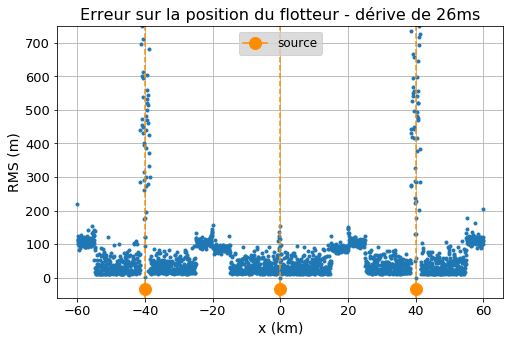

In [38]:
plt.figure(figsize=(8,5))
## plot rms result
ax2 = plt.subplot(111)
ax2.grid()
plt.plot(X/1.e3, RMS_t26, '.') 
plt.xlabel('x (km)', fontsize=14)
plt.ylabel('RMS (m)', fontsize=14)
plt.title('Erreur sur la position du flotteur - dérive de 26ms', fontsize=16 )

plt.plot(sources3[0].x_s/1.e3, -35, color='darkorange', marker='o', markersize=12)
plt.plot(sources3[1].x_s/1.e3, -35, color='darkorange', marker='o', markersize=12)
plt.plot(sources3[2].x_s/1.e3, -35, color='darkorange', marker='o', markersize=12, label='source')
plt.plot([sources3[0].x_s/1.e3,sources3[0].x_s/1.e3],[-70,750],'--', color='darkorange')
plt.plot([sources3[1].x_s/1.e3,sources3[1].x_s/1.e3],[-70,750],'--', color='darkorange')
plt.plot([sources3[2].x_s/1.e3,sources3[2].x_s/1.e3],[-70,750],'--', color='darkorange')

plt.legend(fontsize=12, facecolor='lightgrey')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim([-60, 750])

plt.savefig('etp_variable_26ms', dpi=100)

Text(0.5,1,'Biais sur la position du flotteur - dérive de 26ms')

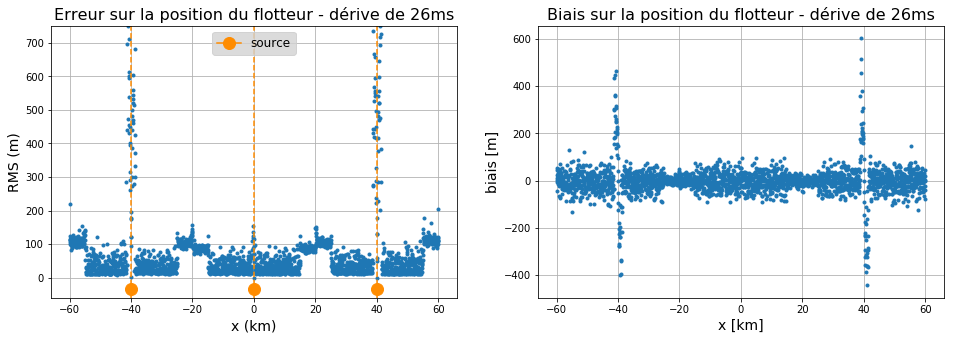

In [34]:
plt.figure(figsize=(16,5))
## plot rms result
ax2 = plt.subplot(121)
ax2.grid()
plt.plot(X/1.e3, RMS_t26, '.') 
plt.xlabel('x (km)', fontsize=14)
plt.ylabel('RMS (m)', fontsize=14)
plt.title('Erreur sur la position du flotteur - dérive de 26ms', fontsize=16 )

plt.plot(sources3[0].x_s/1.e3, -35, color='darkorange', marker='o', markersize=12)
plt.plot(sources3[1].x_s/1.e3, -35, color='darkorange', marker='o', markersize=12)
plt.plot(sources3[2].x_s/1.e3, -35, color='darkorange', marker='o', markersize=12, label='source')
plt.plot([sources3[0].x_s/1.e3,sources3[0].x_s/1.e3],[-70,750],'--', color='darkorange')
plt.plot([sources3[1].x_s/1.e3,sources3[1].x_s/1.e3],[-70,750],'--', color='darkorange')
plt.plot([sources3[2].x_s/1.e3,sources3[2].x_s/1.e3],[-70,750],'--', color='darkorange')

plt.legend(fontsize=12, facecolor='lightgrey')

plt.ylim([-60, 750])


## plot bias
ax3  = plt.subplot(122)
ax3.grid()
plt.plot(X/1.e3, BiasX_t26, '.')

plt.xlabel('x [km]', fontsize=14)
plt.ylabel('biais [m]', fontsize=14)
plt.title('Biais sur la position du flotteur - dérive de 26ms', fontsize=16)

#plt.savefig('transect_0', dpi=100)

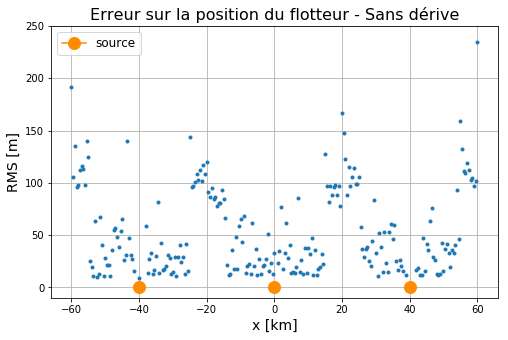

In [175]:
plt.figure(figsize=(8,5))
## plot rms result
ax2 = plt.subplot(111)
ax2.grid()
plt.plot(X/1.e3, RMS_t, '.') 
plt.xlabel('x [km]', fontsize=14)
plt.ylabel('RMS [m]', fontsize=14)
plt.title('Erreur sur la position du flotteur - Sans dérive', fontsize=16 )

plt.plot(sources3[0].x_s/1.e3, -0.03, color='darkorange', marker='o', markersize=12)
plt.plot(sources3[1].x_s/1.e3, -0.03, color='darkorange', marker='o', markersize=12)
plt.plot(sources3[2].x_s/1.e3, -0.03, color='darkorange', marker='o', markersize=12, label='source')
plt.plot([sources3[0].x_s/1.e3,sources3[0].x_s/1.e3],[-0.05,0.40],'--', color='darkorange')
plt.plot([sources3[1].x_s/1.e3,sources3[1].x_s/1.e3],[-0.05,0.40],'--', color='darkorange')
plt.plot([sources3[2].x_s/1.e3,sources3[2].x_s/1.e3],[-0.05,0.40],'--', color='darkorange')

plt.ylim([-10, 250])
plt.legend(fontsize=12)

In [65]:
### Création du transect
L = 120.* 1.e3
X = np.linspace(-L/2.,L/2.,2401)  # resolution : 50m
Y = 0. 

In [66]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_t, BiasX_t, Success_t = transect (sources3, X, Y, Nmc, var, clock_drift = False ) 

FloatProgress(value=0.0, description='Loading :')

In [67]:
np.save('RMS_variable_nodrift1', RMS_t)
np.save('BIAS_variable_nodrift1', BiasX_t)

In [74]:
RMS_t = np.load('RMS_variable_nodrift1.npy')
BiasX_t = np.load('BIAS_variable_nodrift1.npy')

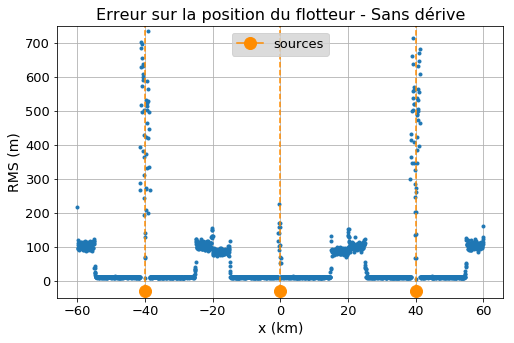

In [82]:
plt.figure(figsize=(8,5))
## plot rms result
ax2 = plt.subplot(111)
ax2.grid()
plt.plot(X/1.e3, RMS_t, '.') 
plt.xlabel('x (km)', fontsize=14)
plt.ylabel('RMS (m)', fontsize=14)
plt.title('Erreur sur la position du flotteur - Sans dérive', fontsize=16 )

plt.plot(sources3[0].x_s/1.e3, -30, color='darkorange', marker='o', markersize=12)
plt.plot(sources3[1].x_s/1.e3, -30, color='darkorange', marker='o', markersize=12)
plt.plot(sources3[2].x_s/1.e3, -30, color='darkorange', marker='o', markersize=12, label='sources')
plt.plot([sources3[0].x_s/1.e3,sources3[0].x_s/1.e3],[-50,750],'--', color='darkorange')
plt.plot([sources3[1].x_s/1.e3,sources3[1].x_s/1.e3],[-50,750],'--', color='darkorange')
plt.plot([sources3[2].x_s/1.e3,sources3[2].x_s/1.e3],[-50,750],'--', color='darkorange')

plt.legend(fontsize=13, facecolor='lightgrey')

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim([-50, 750])


## plot bias
#ax3  = plt.subplot(122)
#ax3.grid()
#plt.plot(X/1.e3, BiasX_t, '.')

#plt.xlabel('x (km)', fontsize=14)
#plt.ylabel('biais (m)', fontsize=14)
#plt.title('Biais sur la position du flotteur - Sans dérive', fontsize=16)

plt.savefig('transect_erreur_variable', dpi=100)

In [42]:
L = 120.* 1.e3
X1 = np.linspace(-42.e3,-38.e3,201)  # resolution : 20m
Y1 = 0. 

In [43]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_tS1, BiasX_tS1, Success_tS1 = transect (sources3, X1, Y1, Nmc, var, clock_drift = False ) 

FloatProgress(value=0.0, description='Loading :')

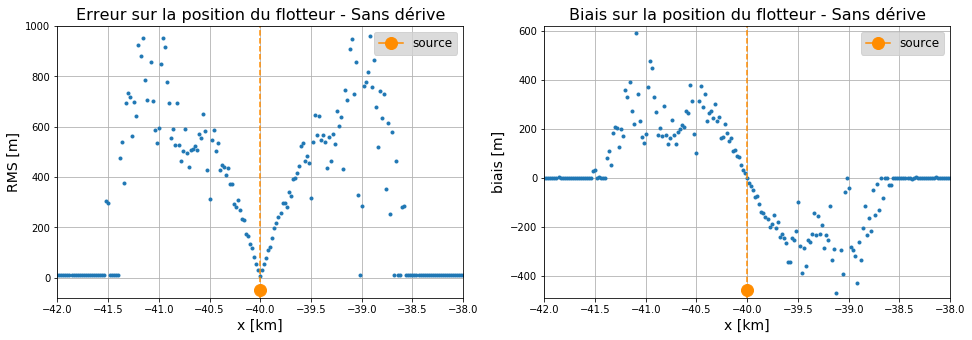

In [60]:
plt.figure(figsize=(16,5))
## plot rms result
ax2 = plt.subplot(121)
ax2.grid()
plt.plot(X1/1.e3, RMS_tS1, '.') 
plt.xlabel('x [km]', fontsize=14)
plt.ylabel('RMS [m]', fontsize=14)
plt.title('Erreur sur la position du flotteur - Sans dérive', fontsize=16 )

#plt.plot(sources3[0].x_s/1.e3, -30, color='darkorange', marker='o', markersize=12)
plt.plot(sources3[1].x_s/1.e3, -50, color='darkorange', marker='o', markersize=12, label='source')
#plt.plot(sources3[2].x_s/1.e3, -30, color='darkorange', marker='o', markersize=12, label='source')
#plt.plot([sources3[0].x_s/1.e3,sources3[0].x_s/1.e3],[-50,750],'--', color='darkorange')
plt.plot([sources3[1].x_s/1.e3,sources3[1].x_s/1.e3],[-80,1000],'--', color='darkorange')
#plt.plot([sources3[2].x_s/1.e3,sources3[2].x_s/1.e3],[-50,750],'--', color='darkorange')

plt.legend(fontsize=12, facecolor='lightgrey')

plt.ylim([-80, 1000])
plt.xlim([-42.,-38.])

## plot bias
ax3  = plt.subplot(122)
ax3.grid()
plt.plot(X1/1.e3, BiasX_tS1, '.')

plt.plot(sources3[1].x_s/1.e3, -460, color='darkorange', marker='o', markersize=12, label='source')
plt.plot([sources3[1].x_s/1.e3,sources3[1].x_s/1.e3],[-490,620],'--', color='darkorange')
plt.ylim([-490, 620])
plt.xlim([-42.,-38.])

plt.xlabel('x [km]', fontsize=14)
plt.ylabel('biais [m]', fontsize=14)
plt.title('Biais sur la position du flotteur - Sans dérive', fontsize=16)
plt.legend(fontsize=12, facecolor='lightgrey')


#plt.savefig('transect_0', dpi=100)

In [61]:
L = 120.* 1.e3
X2 = np.linspace(-2.e3,2.e3,201)  # resolution : 20m
Y2 = 0. 

In [62]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_tS2, BiasX_tS2, Success_tS2 = transect (sources3, X2, Y2, Nmc, var, clock_drift = False ) 

FloatProgress(value=0.0, description='Loading :')

Text(0.5,1,'Biais sur la position du flotteur - Sans dérive')

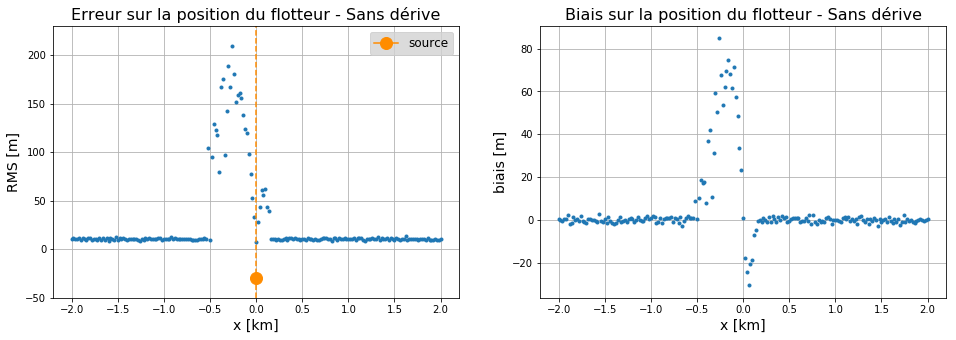

In [64]:
plt.figure(figsize=(16,5))
## plot rms result
ax2 = plt.subplot(121)
ax2.grid()
plt.plot(X2/1.e3, RMS_tS2, '.') 
plt.xlabel('x [km]', fontsize=14)
plt.ylabel('RMS [m]', fontsize=14)
plt.title('Erreur sur la position du flotteur - Sans dérive', fontsize=16 )

plt.plot(sources3[0].x_s/1.e3, -30, color='darkorange', marker='o', markersize=12, label='source')
#plt.plot(sources3[1].x_s/1.e3, -30, color='darkorange', marker='o', markersize=12)
#plt.plot(sources3[2].x_s/1.e3, -30, color='darkorange', marker='o', markersize=12, label='source')
plt.plot([sources3[0].x_s/1.e3,sources3[0].x_s/1.e3],[-50,750],'--', color='darkorange')
#plt.plot([sources3[1].x_s/1.e3,sources3[1].x_s/1.e3],[-50,750],'--', color='darkorange')
#plt.plot([sources3[2].x_s/1.e3,sources3[2].x_s/1.e3],[-50,750],'--', color='darkorange')

plt.legend(fontsize=12, facecolor='lightgrey')

plt.ylim([-50, 230])


## plot bias
ax3  = plt.subplot(122)
ax3.grid()
plt.plot(X2/1.e3, BiasX_tS2, '.')

plt.xlabel('x [km]', fontsize=14)
plt.ylabel('biais [m]', fontsize=14)
plt.title('Biais sur la position du flotteur - Sans dérive', fontsize=16)

#plt.savefig('transect_0', dpi=100)